# Start

In [1]:
import pandas as pd
import numpy as np
import re
import random
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
from tqdm import tqdm

from torch.utils.data import Dataset
import torch.optim as optim
from torch import nn
import torch

import warnings
warnings.filterwarnings("ignore")

In [2]:
seed=1
random.seed(seed)
os.environ['PYTHONHASHSEED']  = str(seed)
np.random.seed(seed)

In [85]:
from google.colab import files
uploaded = files.upload()

Saving Suicide_Detection_with_topics_balanced.csv to Suicide_Detection_with_topics_balanced.csv


In [86]:
df = pd.read_csv('Suicide_Detection_with_topics_balanced.csv')

In [87]:
# Drop non-suicide texts as we don't need them here
indices_to_drop = df[df['class'] == 'non-suicide'].index
df.drop(indices_to_drop, inplace=True)
df.reset_index(drop=True, inplace=True)

# EDA

In [88]:
df.head()

,id,text,class,topic
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,6
1,8,i need helpjust help me im crying so hard,suicide,1
2,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,3
3,11,Honetly idkI dont know what im even doing here...,suicide,2
4,12,[Trigger warning] Excuse for self inflicted bu...,suicide,8


In [89]:
texts = df['text']
texts

0        Ex Wife Threatening SuicideRecently I left my ...
1                i need helpjust help me im crying so hard
2        I’m so lostHello, my name is Adam (16) and I’v...
3        Honetly idkI dont know what im even doing here...
4        [Trigger warning] Excuse for self inflicted bu...
                               ...                        
14995    I guess I will kill myself as soon as I can.Go...
14996    Not me, but saw a concerning post at /r/depres...
14997    Feeling like crap tonightHi SW, so I'm feeling...
14998    This is it i guess..Everything is just wrong a...
14999    Family found about my drugsSo, Im 22yrs old an...
Name: text, Length: 15000, dtype: object

In [90]:
import re

formatted_texts = texts.apply(lambda x: re.sub(r"(@\[A-Za-z0-9']+)|(\w+:\/\/\S+)|^rt|http.+?", "", x))
formatted_texts = [text.replace("'", " ") for text in formatted_texts]
formatted_texts = [text.replace("’", " ") for text in formatted_texts]
texts = [text.lower() for text in formatted_texts]
texts[:5]

['ex wife threatening suiciderecently i left my wife for good because she has cheated on me twice and lied to me so much that i have decided to refuse to go back to her. as of a few days ago, she began threatening suicide. i have tirelessly spent these paat few days talking her out of it and she keeps hesitating because she wants to believe i ll come back. i know a lot of people will threaten this in order to get their way, but what happens if she really does? what do i do and how am i supposed to handle her death on my hands? i still love my wife but i cannot deal with getting cheated on again and constantly feeling insecure. i m worried today may be the day she does it and i hope so much it doesn t happen.',
 'i need helpjust help me im crying so hard',
 'i m so losthello, my name is adam (16) and i ve been struggling for years and i m afraid. through these past years thoughts of suicide, fear, anxiety i m so close to my limit . i ve been quiet for so long and i m too scared to come 

In [91]:
df['topic'].value_counts()

6    1875
1    1875
3    1875
2    1875
8    1875
7    1875
4    1875
5    1875
Name: topic, dtype: int64

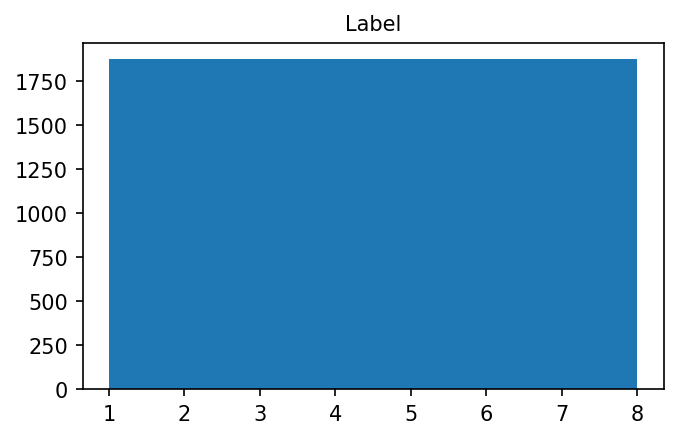

In [92]:
plt.figure(figsize=(5, 3), dpi=150)
plt.title("Label", fontsize=10)
plt.hist(df["topic"], bins=8);

In [93]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [94]:
def remove_punctuation(tokenized_texts: list) -> list:
    filtered_texts = []
    for tokenized_text in tokenized_texts:
        filtered_texts.append([re.sub(r"[^0-9A-Za-z]", "", token) for token in tokenized_text if re.sub(r"[^0-9A-Za-z]", "", token).strip()])
    return filtered_texts

In [95]:
def clean_stopwords(tokenized_texts: list) -> list:
    filtered_texts = []
    for tokenized_text in tokenized_texts:
        filtered_texts.append([word for word in tokenized_text if word.lower() not in [*stop_words, 'im']])
    return filtered_texts

In [96]:
tokenized_texts = []
for text in texts:
  tokenized_texts.append(nltk.word_tokenize(text))

In [97]:
tokenized_texts = remove_punctuation(tokenized_texts)
tokenized_texts = clean_stopwords(tokenized_texts)

In [98]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [99]:
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
lemmatized_texts_wo_punct = []
for clean_tokenized_text in tokenized_texts:
  lemmatized_texts_wo_punct.append([wnl.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] else wnl.lemmatize(i) for i,j in pos_tag(clean_tokenized_text)])

In [100]:
lemmatized_texts_wo_punct = clean_stopwords(lemmatized_texts_wo_punct)
lemmatized_texts_wo_punct = [' '.join(text) for text in lemmatized_texts_wo_punct]

In [101]:
!pip install -U sentence-transformers

In [102]:
from sentence_transformers import SentenceTransformer

model_st = SentenceTransformer('all-MiniLM-L6-v2')

In [103]:
labels = df["topic"]
labels = [label - 1 for label in labels]

In [128]:
X_train, X_test, y_train, y_test = train_test_split(lemmatized_texts_wo_punct, labels, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [105]:
print(f'len(X_train) = {len(X_train)}')
print(f'len(y_train) = {len(y_train)}')
print(f'len(X_val) = {len(X_val)}')
print(f'len(y_val) = {len(y_val)}')
print(f'len(X_test) = {len(X_test)}')
print(f'len(y_test) = {len(y_test)}')

len(X_train) = 9000
len(y_train) = 9000
len(X_val) = 3000
len(y_val) = 3000
len(X_test) = 3000
len(y_test) = 3000


In [106]:
X_train_emb = model_st.encode(X_train)
X_val_emb = model_st.encode(X_val)
X_test_emb = model_st.encode(X_test)

# Model

In [231]:
model = nn.Sequential(
    nn.Linear(X_train_emb.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 8)
).to("cpu")

In [232]:
class CustomDataset(Dataset):
    def __init__(self, input_df, target_df, transform=None):
        self.input_df = input_df
        self.target_df = target_df
        self.transform = transform

    def __len__(self):
        return len(self.input_df)

    def __getitem__(self, index):
        input_tensor = torch.tensor(self.input_df[index], dtype=torch.float32)
        target_tensor = torch.tensor(self.target_df[index], dtype=torch.float32)
        return input_tensor, target_tensor

In [233]:
y_train_array = np.array(y_train)
y_test_array = np.array(y_test)
y_val_array = np.array(y_val)

In [234]:
train_dataloader = torch.utils.data.DataLoader(CustomDataset(X_train_emb, y_train_array), 64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(CustomDataset(X_val_emb, y_val_array), 64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(CustomDataset(X_test_emb, y_test_array), 1, shuffle=False)

In [235]:
def train_and_validate(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs):
    train_loss = []
    val_losses = []

    for epoch in range(n_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_dataloader):
            optimizer.zero_grad()
            outputs = model(inputs.view(inputs.size(0), -1))
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i == len(train_dataloader) - 1:
              train_epoch_loss = running_loss / len(train_dataloader)
              train_loss.append(train_epoch_loss)
              print('Epoch %d | Training loss: %.3f' % (epoch+1, train_epoch_loss))

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():  # If we make validation there is no need to track gradients
            for i, (inputs, labels) in enumerate(val_dataloader):
                outputs = model(inputs.view(inputs.size(0), -1))
                val_loss = criterion(outputs, labels.long())
                running_val_loss += val_loss.item()
                if i == len(val_dataloader) - 1:
                  val_epoch_loss = running_val_loss / len(val_dataloader)
                  val_losses.append(val_epoch_loss)
                  print('Epoch %d | Validation loss: %.3f' % (epoch+1, val_epoch_loss))
                  print('--------------------------------')

    # Plotting training and validation loss
    plt.plot(range(1, len(train_loss)+1), train_loss, label='Training Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

Epoch 1 | Training loss: 1.990
Epoch 1 | Validation loss: 1.807
--------------------------------
Epoch 2 | Training loss: 1.671
Epoch 2 | Validation loss: 1.612
--------------------------------
Epoch 3 | Training loss: 1.534
Epoch 3 | Validation loss: 1.530
--------------------------------
Epoch 4 | Training loss: 1.450
Epoch 4 | Validation loss: 1.473
--------------------------------
Epoch 5 | Training loss: 1.385
Epoch 5 | Validation loss: 1.443
--------------------------------
Epoch 6 | Training loss: 1.341
Epoch 6 | Validation loss: 1.414
--------------------------------
Epoch 7 | Training loss: 1.309
Epoch 7 | Validation loss: 1.398
--------------------------------
Epoch 8 | Training loss: 1.278
Epoch 8 | Validation loss: 1.396
--------------------------------
Epoch 9 | Training loss: 1.257
Epoch 9 | Validation loss: 1.372
--------------------------------
Epoch 10 | Training loss: 1.237
Epoch 10 | Validation loss: 1.371
--------------------------------


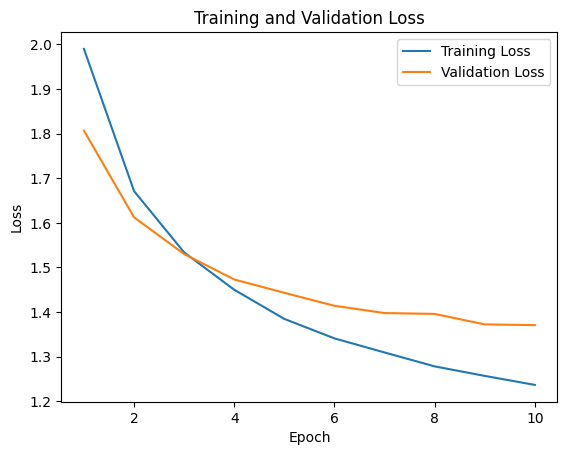

In [236]:
criterion = nn.CrossEntropyLoss() # Chose loss for multiclass classification
# As you can see higher I didn't use Softmax activation function as the last activation function
# because CrossEntropyLoss already applies nn.LogSoftmax() + nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # An optimizer that usually works best

train_and_validate(model, criterion, optimizer, train_dataloader, val_dataloader, 10)

In [237]:
def get_predictions(model, test_dataloader):
  total_loss = 0
  total_correct = 0
  predictions = []

  with torch.no_grad():
      for inputs, targets in test_dataloader:
          output = model(inputs)
          _, predicted = torch.max(output, 1) # Get the predicted class with the highest probability
          total_correct += (predicted == targets).sum().item() # Accumulate total correct predictions
          predictions.extend(predicted.tolist())
  return predictions

In [238]:
print(classification_report(y_test_array, get_predictions(model, test_dataloader)))

              precision    recall  f1-score   support

           0       0.56      0.53      0.54       350
           1       0.39      0.34      0.37       387
           2       0.40      0.56      0.47       363
           3       0.63      0.59      0.61       390
           4       0.54      0.48      0.51       337
           5       0.57      0.66      0.61       404
           6       0.56      0.34      0.43       390
           7       0.64      0.76      0.69       379

    accuracy                           0.53      3000
   macro avg       0.54      0.53      0.53      3000
weighted avg       0.54      0.53      0.53      3000

